In [21]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan
import os

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

import itertools
colours = itertools.cycle(('r', 'b', 'g', 'orange', 'purple', 'k'))

%matplotlib inline

In [22]:
#Import output data
output = pd.read_csv('../data/output_front.csv')
#IDs = [(output.loc[output['ID'] == random.choice(output['ID'])]).iloc[0]['Numax'] for i in range(5)]
df_met = pd.read_csv('../data/APOKASCfull.csv')
df_class = pd.read_csv('../data/RGclassification.txt', header=None, delim_whitespace=True, names=['KIC', 'type'])

#Set numax range so stars are chosen with similar size echelles
#rng = 30
#numax_tgt = 75
#output = output.loc[(np.abs(output['numax'] - numax_tgt) < rng)].reset_index(drop=True)

#Number of stars to model (between 1 and 1212) and star classification (RGB, RC, 2CL)
nStars = 3
RGclass = 'RGB'

#Selects a random sample of stars from the file, recording their IDs and makes sure the stars exist in APOKASC fil
IDs = []*nStars
Phi = []
i = 0
while i < nStars:
    nextID = random.choice(output['kic'])
    #if df_class.loc[df_class['KIC'] == nextID].type.values == RGclass:
    for j in range(len(df_met.KIC)):
        if nextID == df_met.KIC[j]:
            if df_class.loc[df_class['KIC'] == nextID].type.values == 'RGB':
                Phi.append(1.71)
            elif df_class.loc[df_class['KIC'] == nextID].type.values == 'RC' or df_class.loc[df_class['KIC'] == nextID].type.values == '2CL':
                Phi.append(-0.43)
            else:
                Phi.append(0)
            IDs.append(nextID)
            i += 1

#Add the Elsworth classification

#Chooses specific stars each time
#IDs = [8759811, 10416550, 8824452, 11821439, 9470276]

# Create a list of the numax values and errors corresponding to each ID
Numax = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax_err'] for i in range(len(IDs))]

#print(IDs)
print(Phi)

[-0.43, 1.71, 1.71]


In [23]:
'''output = pd.read_csv('../data/output_back_filesremoved.csv', usecols=[1,11,24])
#print(len(output.kic.values))
Phis = []
for j in output.kic:
        if df_class.loc[df_class['KIC'] == j].type.values == 'RGB':
            Phis.append(1.71)
        elif df_class.loc[df_class['KIC'] == j].type.values == 'RC' or df_class.loc[df_class['KIC'] == j].type.values == '2CL':
            Phis.append(-0.43)
            #print('yes')
        else:
            Phis.append(0)
output['Phistart'] = Phis
display(output.head())
output.to_csv('../data/output_front.csv')'''

"output = pd.read_csv('../data/output_back_filesremoved.csv', usecols=[1,11,24])\n#print(len(output.kic.values))\nPhis = []\nfor j in output.kic:\n        if df_class.loc[df_class['KIC'] == j].type.values == 'RGB':\n            Phis.append(1.71)\n        elif df_class.loc[df_class['KIC'] == j].type.values == 'RC' or df_class.loc[df_class['KIC'] == j].type.values == '2CL':\n            Phis.append(-0.43)\n            #print('yes')\n        else:\n            Phis.append(0)\noutput['Phistart'] = Phis\ndisplay(output.head())\noutput.to_csv('../data/output_front.csv')"

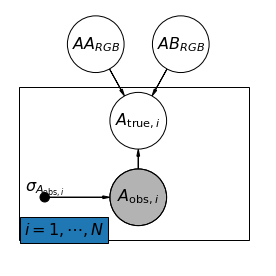

In [24]:
#Create acyclic graph (probabalistic graphical model)
from matplotlib import rc
rc("font", family="serif", size=16)
import daft
pgm = daft.PGM([3,3], grid_unit=3, node_unit=2)
# Hierarchical parameters.
pgm.add_node(daft.Node("AA", r"$AA_{RGB}$", 1.0, 2.6))
pgm.add_node(daft.Node("AB", r"$AB_{RGB}$", 2.0, 2.6))
# Add latent variables 
pgm.add_node(daft.Node("A_true", r"$A_{{\rm true},i}$", 1.5, 1.7))
# Data.
pgm.add_node(daft.Node("A_obs", r"$A_{{\rm obs},i}$", 1.5, 0.8, observed=True))
pgm.add_node(daft.Node("Aerr", r"$\sigma_{A_{{\rm obs},i}}$", 0.4, 0.8, fixed=True, offset=[0.0,0.4]))
# Add in the edges.
pgm.add_edge("AA", "A_true")
pgm.add_edge("AB", "A_true")
pgm.add_edge("A_obs", "A_true")
pgm.add_edge("Aerr", "A_obs")
# And a plate.
pgm.add_plate(daft.Plate([0.1, 0.4, 2.7, 1.7], label=r"$i = 1, \cdots, N$",
    shift=-0.1))
# Render and save.
pgm.render()

In [25]:
#Import mode data and construct arrays for storing orders and frequencies
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0']) for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])

#Sort values by frequency and assign order and calculate avg dnu
dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    #(due to some stars having fewer mode frequencies observed)
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            #modesID[i].loc[l] = [l, int(np.max(modesID[i]['n']+l)), (np.max(modesID[i]['dnu'])+dnu_avgID[i]), np.nan , 10000]
            #app = pd.DataFrame([(np.max(modesID[i]['dnu'])+dnu_avgID[i]), 10000], columns=['n', 'f0', 'f0_err'])
            #modesID[i].append(app, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
dnu_avgarr = np.asarray(dnu_avgID)

<IPython.core.display.Javascript object>


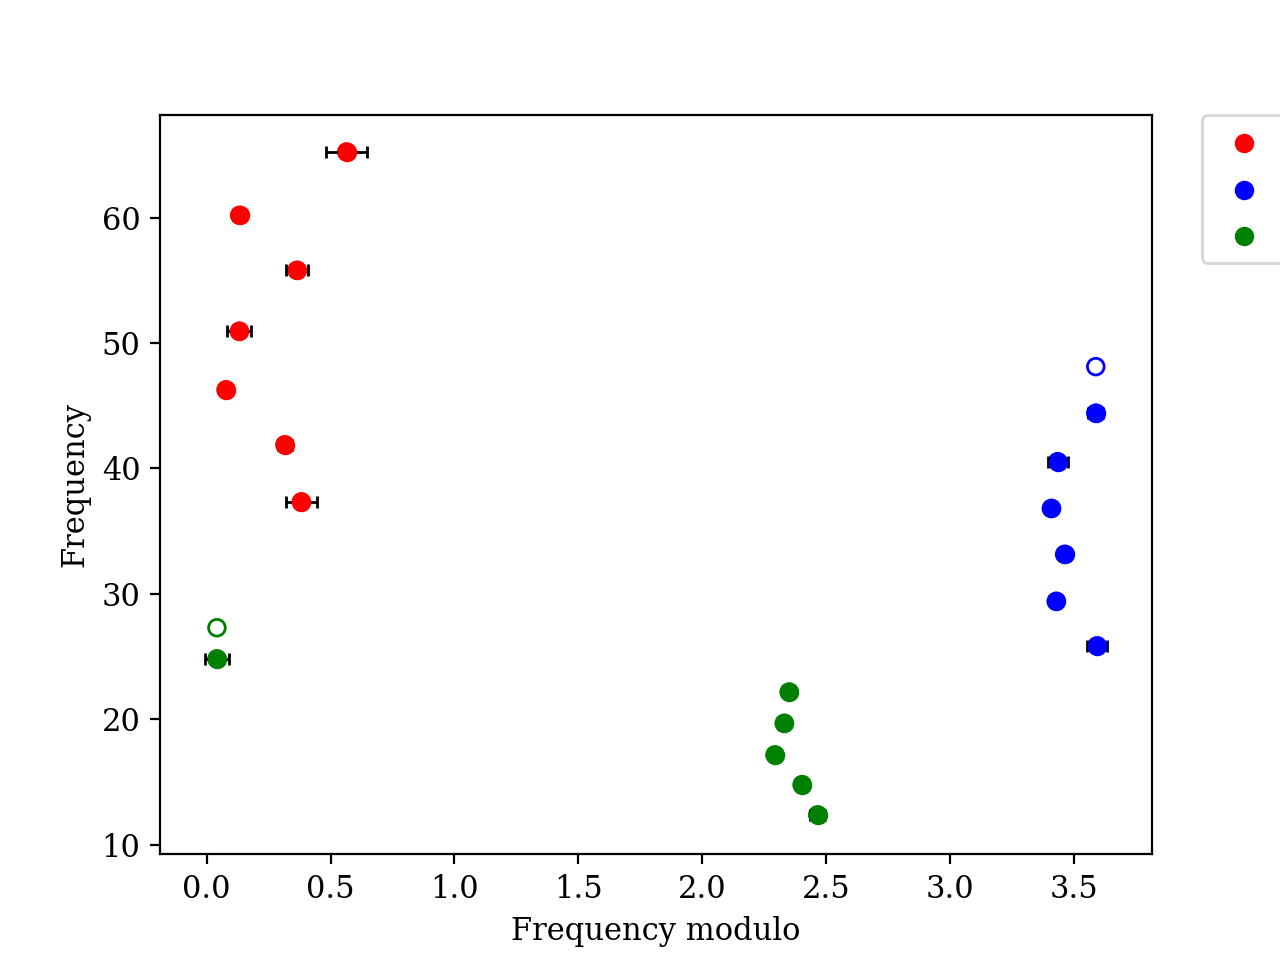

In [31]:
%matplotlib notebook
#Construct and plot echelles for each star
for i in np.arange(0,len(IDs),1):
    # Iterate point colour
    colour = next(colours)
    # Plot all frequencies, and errorbars for the 'true' data
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    plt.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'KIC = '+str(IDs[i]), c=colour)
    plt.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)

#for i in np.arange(0,len(IDs),1):
    #plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
numax_err = Numax_err
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
#A = np.ones([len(IDs)])*0.05 
A = 0.6*dnu_avgarr**(-0.88)
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*1000
phi = np.ones([len(IDs)])*1.71

plt.ylabel('Frequency')
plt.xlabel(r'Frequency modulo')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#print(A)

In [34]:
# First run with no decay term
code = '''
functions{
    real asex(real n, real dnu, real numax, real epsilon, real alpha, real A, real G, real phi){
        real nmax = numax/dnu - epsilon;
        return (n + epsilon + (alpha/2) * (nmax - n)^2 + 
                A*G/(2*pi()) * sin((2*pi()*(n-nmax))/G + phi))*dnu;
    }
}
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real dnu_guess[N];
    real numax_obs[N];
    real numax_err[N];
}
parameters {
    // Normal Parameters
    real dnu[N];
    real<lower = 0> numax[N];
    real <lower = 0> G[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];  
    
    //Hierarchical parameters
    real epsilon_std[N];
    real<lower = 0> eps_sig;
    real epsA;
    real epsB;
    
    real alpha_std[N];
    real<lower = 0> al_sig;
    real alA;
    real alB;
    
    //real <lower = 0> A[N];
    real A_std[N];
    real<lower = 0> A_sig;
    real AA;
    real AB;
    
    //real G_std[N];
    //real<lower = 0> G_sig;
    //real GA;
    //real GB;
      
}

transformed parameters{
    real epsilon[N];
    real alpha[N];
    real A[N];
    //real G[N];
    for (i in 1:N){
        epsilon[i] = epsilon_std[i] * eps_sig + (epsA + epsB * log(dnu[i]));
        alpha[i] = alpha_std[i] * al_sig + (alA * (dnu[i])^(-alB));
        A[i] = A_std[i] * A_sig + (AA*dnu[i]^(-AB));
        //G[i] = G_std[i] * G_sig + (GA*dnu[i]^(-GB));
    }
}
model {
    real mod[M];
    for (i in 1:N){
        for (j in 1:M){
            mod[j] = asex(n[i,j], dnu[i], numax[i], epsilon[i], alpha[i], A[i], G[i], phi[i]);
            //mod[j] ~ normal(freq[i], freq_err[i]);
        }
        freq[i,:] ~ normal(mod, freq_err[i,:]);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.01);
        numax[i] ~ normal(numax_obs[i], numax_err[i]);
        //dnu[i] ~ uniform(0, 20);
        
        //epsilon[i] ~ normal(epsA + epsB*log(dnu[i]), 0.5);
        //alpha[i] ~ lognormal(log(alA*dnu[i]^(-alB)), 0.3);
        //A[i] ~ lognormal(log(AA*dnu[i]^(-AB)), 0.4);
        //epsilon[i] ~ uniform(-0.0, 2.0);
        //alpha[i] ~ lognormal(log(0.015*dnu[i]^(-0.32)), 0.5);
        //A[i] ~ lognormal(log(0.06*dnu[i]^(-0.88)), 0.4);
    }
    G ~ normal(3.08, 0.65);
    //numax ~ normal(numax_obs, numax_err);
    
    //Hyperpriors
    epsilon_std ~ normal(0, 1);
    eps_sig ~ normal(0, 0.5);
    epsA ~ normal(0.601, 0.25);
    epsB ~ normal(0.632, 0.25);
    
    alpha_std ~ normal(0, 1);
    al_sig ~ normal(0, 0.5); 
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    
    A_std ~ normal(0, 1);
    A_sig ~ normal(0, 0.5);
    AA ~ normal(0.06, 0.02);
    AB ~ normal(0.88, 0.05);
    
    //G_std ~ normal(0, 1);
    //G_sig ~ normal(0, 0.5);
    //GA ~ normal(0.75, 0.1);
    //GB ~ normal(0.75, 0.1);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2c68a7d996bc873e0b78ca6323e17ef3 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpskkrqcfr/stanfit4anon_model_2c68a7d996bc873e0b78ca6323e17ef3_926985065101747638.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [35]:
stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'dnu_guess': dnu_avgarr,
         'numax_obs': numax_obs,
         'numax_err': numax_err
        }
start = {'dnu': dnu_avgarr,
         'nmax': nmax,
         'numax': numax_obs,
         'epsilon': epsilon,
         'alpha': alpha,
         'A': A,
         'eps_sig': 0.01,
         'al_sig': 0.01,
         'A_sig': 0.01,
         'G': G,
         'phi': Phi,
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         'AA': 0.06,
         'AB': 0.88
    }
nchains = 4

notau = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

In [36]:
print(notau)

Inference for Stan model: anon_model_2c68a7d996bc873e0b78ca6323e17ef3.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]           4.63  9.4e-5 9.2e-3   4.61   4.62   4.63   4.64   4.65   9540    1.0
dnu[2]            3.7  1.0e-4 9.0e-3   3.68    3.7    3.7   3.71   3.72   7712    1.0
dnu[3]           2.46  7.7e-5 7.5e-3   2.45   2.46   2.46   2.47   2.48   9452    1.0
numax[1]        50.97    0.04   0.31  50.38  50.76  50.97  51.18  51.59     58   1.03
numax[2]        34.47  3.2e-3    0.3  33.86  34.27  34.47  34.67  35.06   8954    1.0
numax[3]        17.87  2.0e-3   0.19  17.49  17.74  17.87   18.0  18.24   9141    1.0
G[1]             2.25    0.75   1.07   0.42   1.16   2.79   2.95   3.18      2   6.98
G[2]             2.77    0.01   0.51    1.7   2.47   2.77   3.09   3.82   1618    1.0
G[3]             2.47  9.3e-3    0.6

In [37]:
#2nd run with decay term
code = '''
functions{
    real asex(real n, real dnu, real numax, real epsilon, real alpha, real A, real G, real phi, real tau){
        real nmax = numax/dnu - epsilon;
        return (n + epsilon + (alpha/2) * (nmax - n)^2 + 
                A*G/(2*pi()) * sin((2*pi()*(n-nmax))/G + phi) * exp(-(n-nmax)/tau)) * dnu;
    }
}
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real dnu_guess[N];
    real numax_obs[N];
    real numax_err[N];
}
parameters {
    real dnu[N];
    real<lower = 0> numax[N];
    real <lower = 0> G[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    real<lower = 0> tau[N];  
    
    //Hierarchical parameters
    real epsilon_std[N];
    real<lower = 0> eps_sig;
    real epsA;
    real epsB;
    
    real alpha_std[N];
    real<lower = 0> al_sig;
    real alA;
    real alB;
    
    //real <lower = 0> A[N];
    real A_std[N];
    real<lower = 0> A_sig;
    real AA;
    real AB;
    
    //real G_std[N];
    //real<lower = 0> G_sig;
    //real GA;
    //real GB;
      
}

transformed parameters{
    real epsilon[N];
    real alpha[N];
    real A[N];
    //real G[N];
    for (i in 1:N){
        epsilon[i] = epsilon_std[i] * eps_sig + (epsA + epsB * log(dnu[i]));
        alpha[i] = alpha_std[i] * al_sig + (alA * (dnu[i])^(-alB));
        A[i] = A_std[i] * A_sig + (AA*dnu[i]^(-AB));
        //G[i] = G_std[i] * G_sig + (GA*dnu[i]^(-GB));
    }
}
model {
    real mod[M];
    for (i in 1:N){
        for (j in 1:M){
            mod[j] = asex(n[i,j], dnu[i], numax[i], epsilon[i], alpha[i], A[i], G[i], phi[i], tau[i]);
            //mod[j] ~ normal(freq[i], freq_err[i]);
        }
        freq[i,:] ~ normal(mod, freq_err[i,:]);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.01);
        numax[i] ~ normal(numax_obs[i], numax_err[i]);
        //dnu[i] ~ uniform(0, 20);
        
        //epsilon[i] ~ normal(epsA + epsB*log(dnu[i]), 0.5);
        //alpha[i] ~ lognormal(log(alA*dnu[i]^(-alB)), 0.3);
        //A[i] ~ lognormal(log(AA*dnu[i]^(-AB)), 0.4);
        //epsilon[i] ~ uniform(-0.0, 2.0);
        //alpha[i] ~ lognormal(log(0.015*dnu[i]^(-0.32)), 0.5);
        //A[i] ~ lognormal(log(0.06*dnu[i]^(-0.88)), 0.4);
    }
    
    G ~ normal(3.08, 0.65);
    tau ~ normal(10, 5);
    //numax ~ normal(numax_obs, numax_err);
    
    //Hyperpriors
    epsilon_std ~ normal(0, 1);
    eps_sig ~ normal(0, 0.5);
    epsA ~ normal(0.601, 0.25);
    epsB ~ normal(0.632, 0.25);
    
    alpha_std ~ normal(0, 1);
    al_sig ~ normal(0, 0.5); 
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    
    A_std ~ student_t(8, 0, 1);
    A_sig ~ normal(0, 0.5);
    AA ~ normal(0.06, 0.02);
    AB ~ normal(0.88, 0.05);
    
    //G_std ~ normal(0, 1);
    //G_sig ~ normal(0, 0.5);
    //GA ~ normal(0.75, 0.1);
    //GB ~ normal(0.75, 0.1);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_18550e2c4b463627fb13d34881b13f32 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpkuxjefmk/stanfit4anon_model_18550e2c4b463627fb13d34881b13f32_35059474959823265.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [38]:
stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'dnu_guess': dnu_avgarr,
         'numax_obs': numax_obs,
         'numax_err': numax_err
        }
start = {'dnu': np.mean(notau['dnu'],axis=0)[:],
         'nmax': nmax,
         'numax': np.mean(notau['numax'],axis=0)[:],
         'epsilon': np.mean(notau['epsilon'],axis=0)[:],
         'alpha': np.mean(notau['alpha'],axis=0)[:],
         'A': np.mean(notau['A'],axis=0)[:],
         'eps_sig': 0.01,
         'al_sig': 0.01,
         'A_sig': 0.01,
         'G': np.mean(notau['G'],axis=0)[:],
         'tau': tau,
         'phi': np.mean(notau['phi'],axis=0)[:],
         'epsA': np.mean(notau['epsA']),
         'epsB': np.mean(notau['epsB']),
         'alA': np.mean(notau['alA']),
         'alB': np.mean(notau['alB']),
         'AA': np.mean(notau['AA']),
         'AB': np.mean(notau['AB'])
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

In [39]:
print(fit)

Inference for Stan model: anon_model_18550e2c4b463627fb13d34881b13f32.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]           4.63  8.9e-5 8.9e-3   4.61   4.62   4.63   4.63   4.64   9976    1.0
dnu[2]            3.7  1.1e-4 9.3e-3   3.68   3.69    3.7   3.71   3.72   7471    1.0
dnu[3]           2.46  7.9e-5 7.6e-3   2.45   2.46   2.46   2.47   2.48   9234    1.0
numax[1]        50.92    0.06    0.3  50.33  50.72  50.91  51.12  51.53     23   1.06
numax[2]        34.47  2.8e-3    0.3  33.89  34.28  34.47  34.67  35.05  10743    1.0
numax[3]        17.87  1.9e-3   0.19   17.5  17.74  17.87  17.99  18.23   9967    1.0
G[1]             2.89    0.02   0.22   2.39   2.77   2.92   3.04   3.25     95   1.02
G[2]             2.82  9.2e-3   0.52   1.75    2.5   2.82   3.15   3.86   3197    1.0
G[3]             2.51  8.4e-3   0.59

<IPython.core.display.Javascript object>


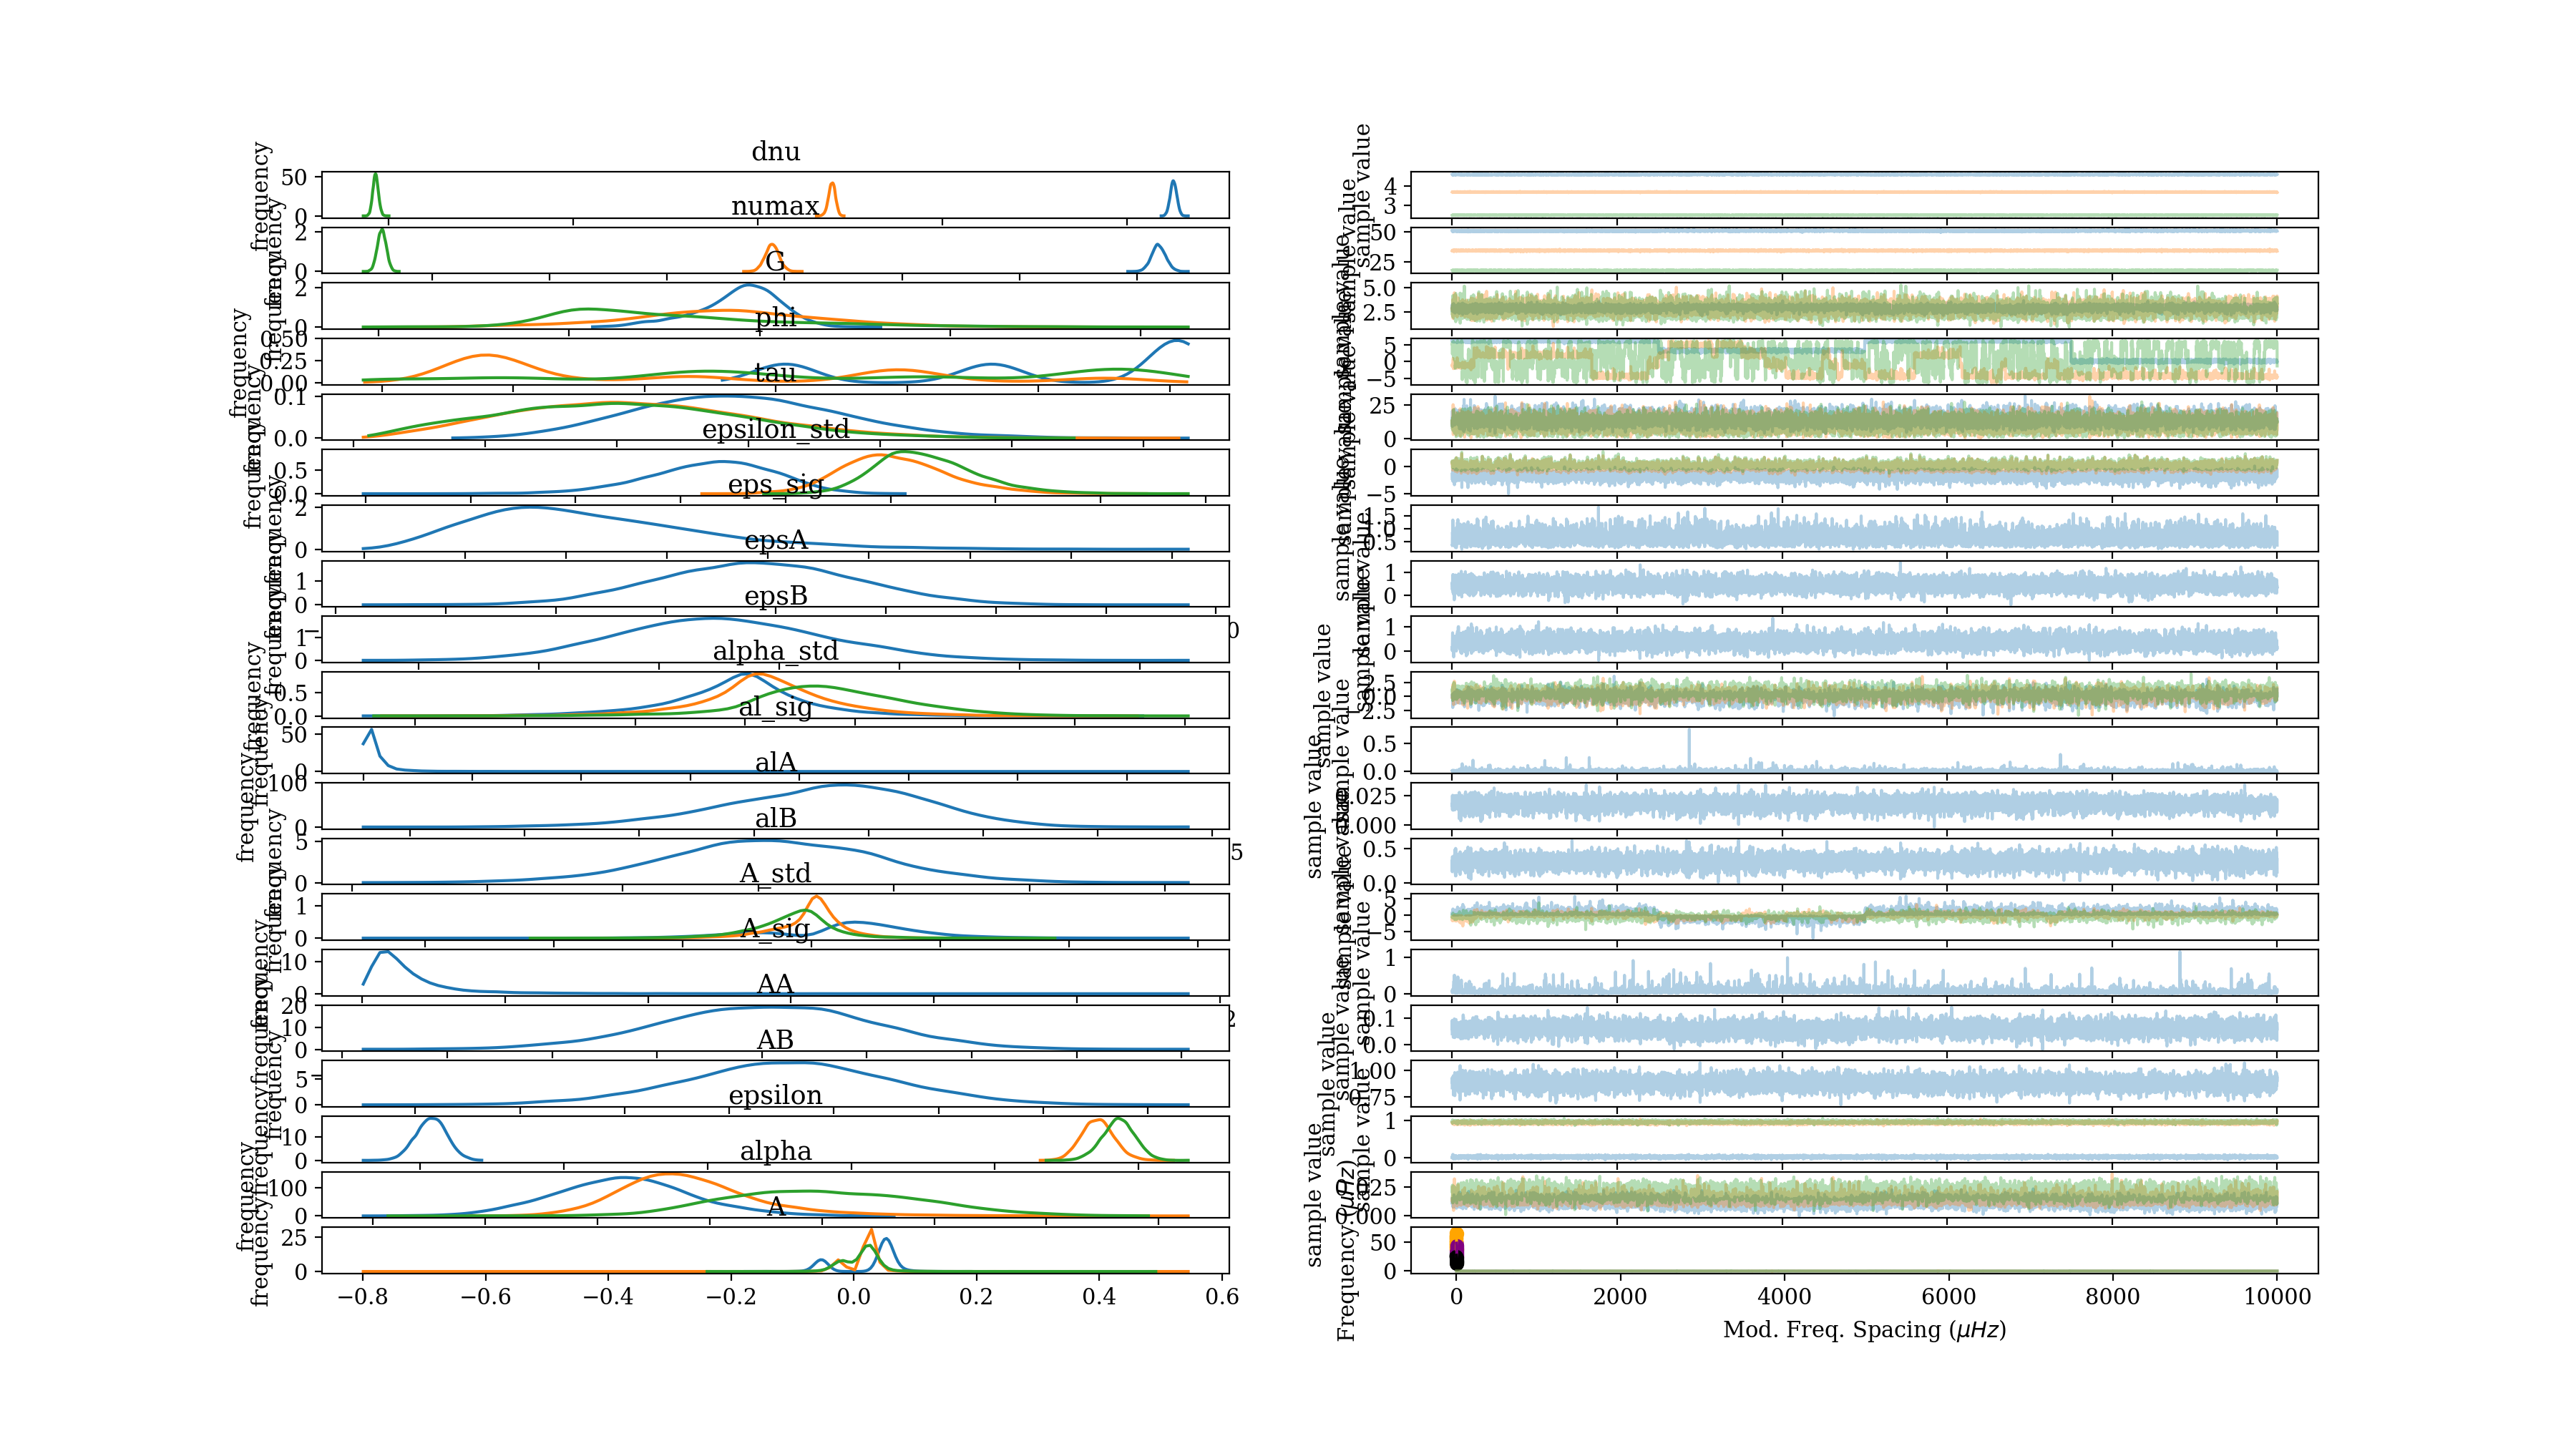

In [40]:
fig = fit.plot()
fig.set_size_inches(18, 10)
fig.show()

In [41]:
def model(n, dnu, numax, epsilon, alpha, A, G, phi, tau):
    nmax = numax/dnu - epsilon
    freqs = (n + epsilon + (alpha/2) * (n - nmax)**2 + ((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi) * np.exp(-(n-nmax)/tau)) * dnu 
    return freqs

<IPython.core.display.Javascript object>


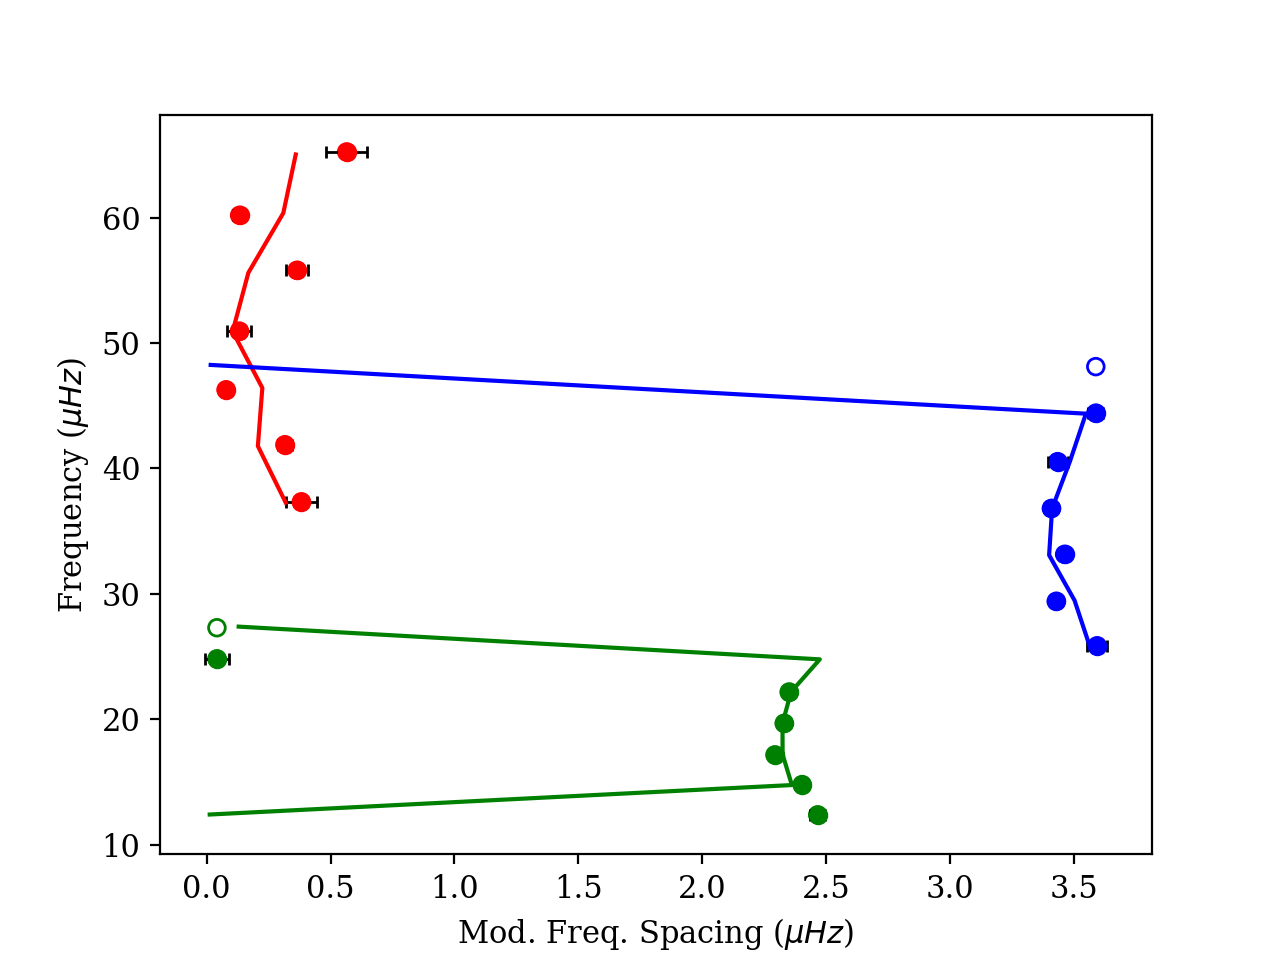

In [46]:
%matplotlib notebook
for i in np.arange(0,len(IDs),1):
    # Iterate point colour
    colour = next(colours)
    # Plot all frequencies, and errorbars for the 'true' data
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    plt.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    plt.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], np.mean(fit['tau'], axis=0)[i])
    plt.plot(g2 % dnu_avgID[i], g2, label='Fit_2D', c=colour)


#Plot stan fitted model on echelle
#for i in range(len(IDs)):
    #plt.figure(len(IDs))
    #plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    #g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          #np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    #plt.plot(g2 % np.mean(fit['dnu'],axis=0)[i], g2, label='Fit_2D')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Mod. Freq. Spacing ($\mu Hz$)')
#plt.xlim(-1,5)
plt.show()



<IPython.core.display.Javascript object>


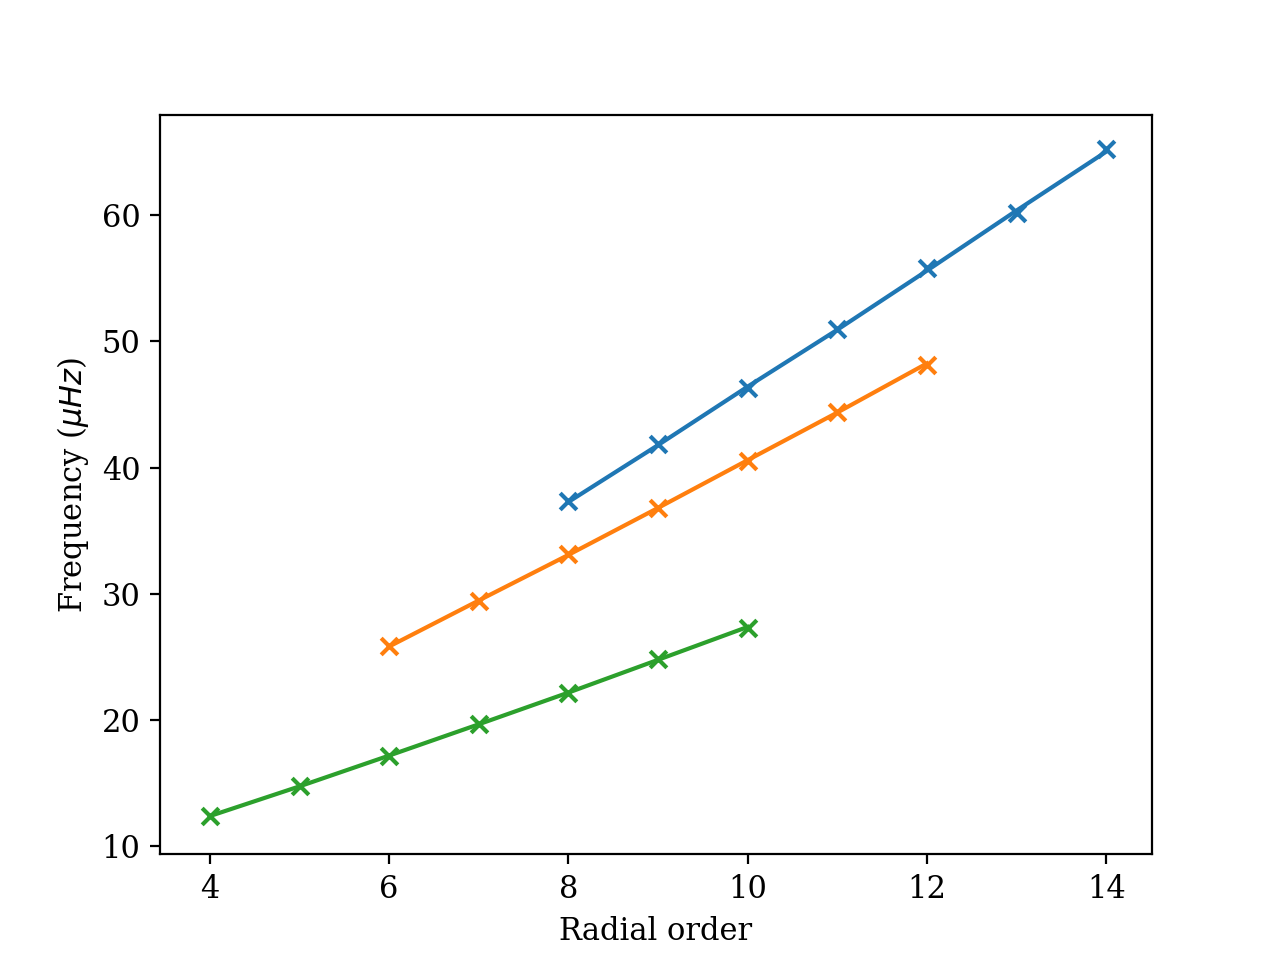

In [43]:
#Plot stan fitted model for freq vs n
for i in range(len(IDs)):
    plt.figure(len(IDs))
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], marker='x', label=r'$l=$'+str(0))
    #plt.errorbar(modesID[i]['f0'] % np.mean(modesID[i]['dnu']), modesID[i]['f0'], xerr=modesID[i]['f0_err'], zorder=0, fmt="none", label="none",
             #c='k', capsize=2, markersize=4, elinewidth=1)
    #np.mean(modesID[i]['dnu'])
    g2 = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i], np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
          np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i], np.mean(fit['phi'], axis=0)[i], 33) #np.mean(fit['tau'], axis=0)[i])
    plt.plot(arr_n[i], g2, label='Fit_2D')

plt.ylabel('Frequency ($\mu Hz$)')
plt.xlabel(f'Radial order')
plt.show()

<IPython.core.display.Javascript object>


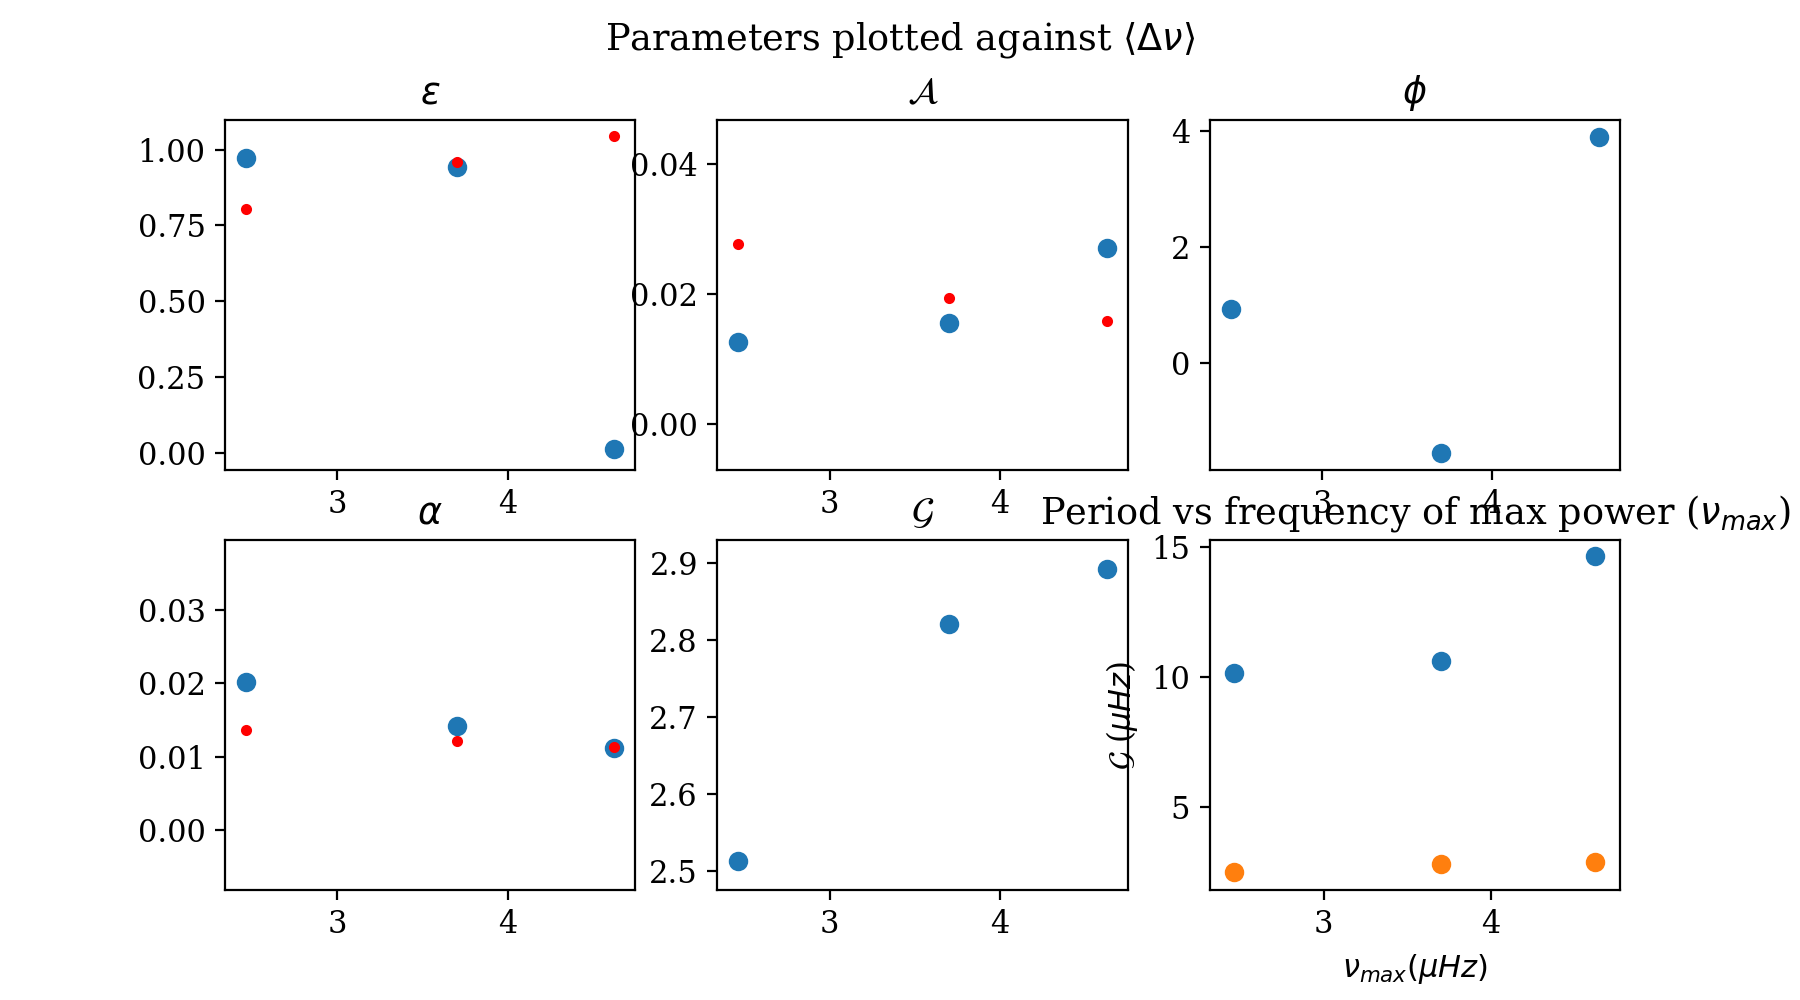

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

In [44]:
#Plot stan deduced parameters against dnu
dnus = []
numaxs = []
epsilons = []
alphas = []
As = []
Gs = []
phis = []
taus = []
for i in range(len(IDs)):
    dnus.append(np.mean(fit['dnu'],axis=0)[i])
    numaxs.append(np.mean(fit['dnu'],axis=0)[i])
    epsilons.append(np.mean(fit['epsilon'],axis=0)[i])
    alphas.append(np.mean(fit['alpha'],axis=0)[i])
    As.append(np.mean(fit['A'],axis=0)[i])
    Gs.append(np.mean(fit['G'],axis=0)[i])
    phis.append(np.mean(fit['phi'],axis=0)[i])
    taus.append(np.mean(fit['tau'],axis=0)[i])
    
fig, axs = plt.subplots(2, 3, figsize=(9, 5), sharey=False, sharex=False)
axs[0,0].scatter(dnus, epsilons)
axs[0,0].plot(dnus, fit['epsA'].mean() + fit['epsB'].mean() * np.log(dnus), '.', c='r')
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, alphas)
axs[1,0].plot(dnus, fit['alA'].mean() * (dnus)**(-fit['alB'].mean()), '.', c='r')
axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, As)
axs[0,1].plot(dnus, fit['AA'].mean() * dnus ** (-fit['AB'].mean()), '.', c='r')
axs[0,1].set_title(r'$\mathcal{A}$')
axs[1,1].scatter(dnus, Gs)
axs[1,1].set_title(r'$\mathcal{G}$')
axs[0,2].scatter(dnus, phis)
axs[0,2].set_title(r'$\phi$')
axs[1,2].scatter(dnus, taus)
axs[1,2].set_title(r'$\tau$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

In [45]:
plt.scatter(numaxs, Gs)
plt.xlabel(r'$\nu_{max} (\mu Hz)$')
plt.ylabel(r'$\mathcal{G}$ ($\mu Hz$)')
plt.title(r'Period vs frequency of max power ($\nu_{max}$)')

Text(0.5, 1.0, 'Period vs frequency of max power ($\\nu_{max}$)')

Text(0, 0.5, 'Glitch amplitude ($\\mu Hz$)')

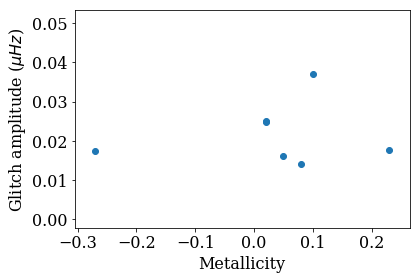

In [18]:
#Plot glitch amplitude against metallicity from APOKASC catalogue
df_met = pd.read_csv('../data/APOKASCfull.csv')
#metals = [(df_met.loc[(df_met['KIC'] == IDs[i])]).loc['[M/H]2'] for i in range(len(IDs))]


#metals = df_met.loc[(df_met['KIC'].isin(IDs))].reset_index(drop=True)

frames = []
for i in range(len(IDs)):
    mets = df_met.loc[df_met['KIC'] == IDs[i]]
    frames.append(mets)

metsall = pd.concat(frames).reset_index(drop=True)

IDdf = pd.DataFrame(IDs)
#ind = IDdf[~IDdf.isin(metsall['KIC'])]

plt.scatter(metsall['[M/H]2'].values, As)
plt.xlabel('Metallicity')
plt.ylabel('Glitch amplitude ($\mu Hz$)')

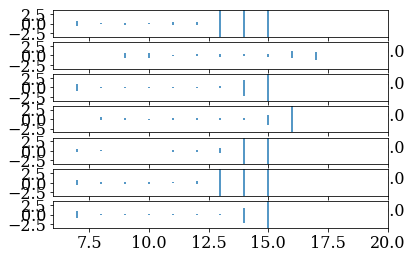

In [19]:
fig, ax = plt.subplots(nStars)
for i in range(nStars):
    g = model(arr_n[i], np.mean(fit['dnu'],axis=0)[i], np.mean(fit['numax'],axis=0)[i],
              np.mean(fit['epsilon'], axis=0)[i], np.mean(fit['alpha'], axis=0)[i],
              np.mean(fit['A'], axis=0)[i], np.mean(fit['G'], axis=0)[i],
              np.mean(fit['phi'], axis=0)[i], np.mean(fit['tau'], axis=0)[i])
    ax[i].errorbar(arr_n[i, :], arr_freq[i,:] - g, yerr=arr_freqerr[i, :]*10, linestyle='none')
    ax[i].set_xlim([6,20])
    ax[i].set_ylim([-3.5, 3.5])